In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

from cbrlib.reasoning.Reasoner import InferenceOptions
from cbrlib.utils.serializer import to_json_string
from cbrlib.evaluation.AssemblyAverageEvaluator import AssemblyAverageEvaluator
from cbrlib.evaluation.LookupTableEvaluator import LookupTableEvaluator
from cbrlib.evaluation.NumberInterpolationEvaluator import NumberInterpolationMetrics, NumberInterpolation, \
    NumberInterpolationEvaluator
from cbrlib.model.AssemblyClass import AssemblyClass
from cbrlib.model.Attribute import Attribute
from cbrlib.model.EnumerationPredicate import EnumerationPredicate
from cbrlib.model.FloatClass import FloatClass
from cbrlib.model.IntegerClass import IntegerClass
from cbrlib.model.RangePredicate import RangePredicate

from cbrlib.model.StringClass import StringClass
from cbrlib.reasoning.LinearReasoner import LinearReasoner

from functools import reduce

from random import choice, randint
import timeit

#plt.style.use('ggplot')

## NumberInterpolationEvaluator

We create a ```price_class``` from ```cbrlib.model.FloatClass``` and set the predicate for this class to be of ```cbrlib.model.RangePredicate``` which gives the boundary of a minimum of 10 and a miximum possible value of 10000. We also define different number interpolation evaluators.

In [23]:
# Define the price class with minimum value of 10 and maximum value of 100000
price_class = FloatClass('Price')
min_ = price_class.create_object(10)
max_ = price_class.create_object(100000)
price_class.set_predicate(RangePredicate(min_, max_))

# Define inperpolation metrics with a tolerance if case is lesser than query of 0
# -> Every case lower than the query will have 0 similarity
metrics = NumberInterpolationMetrics()
metrics.tolerance_if_more = 0.0
less_is_good = NumberInterpolationEvaluator('LessIsGood', min_.get_value(), max_.get_value(), metrics)

# Define the same as above but use an origin value
# The lower the query the smaller is the vicinity
metrics = NumberInterpolationMetrics()
metrics.tolerance_if_more = 0.0
metrics.origin = 10
metrics.use_origin = True
metrics.tolerance_if_more = 0.0
less_is_good_with_origin = NumberInterpolationEvaluator('LessIsGoodUseOrigin',
                                                        min_.get_value(), max_.get_value(), metrics)

metrics = NumberInterpolationMetrics()
metrics.tolerance_if_less = 0.0
metrics.origin = min_.get_value()
metrics.use_origin = True
metrics.tolerance_if_less = 0.3
metrics.tolerance_if_more = 0.1
metrics.linearity_if_less = 0.5
metrics.linearity_if_more = 3
metrics.set_interpolation_if_less(NumberInterpolation.Sigmoid)
metrics.set_interpolation_if_more(NumberInterpolation.Sigmoid)
real_behaviour = NumberInterpolationEvaluator('RealBehaviour',
                                                        min_.get_value(), max_.get_value(), metrics)

Let's generate some lists of values from the different evaluators.

In [24]:
query = price_class.read_object(500)

less_is_good_values = list()
less_is_good_with_origin_values = list()
real_behaviour_values = list()
steps = list()
for i in range(300, 600):
    steps.append(i)
    case = price_class.read_object(i)
    less_is_good_values.append(
        less_is_good.evaluate(query, case))
    less_is_good_with_origin_values.append(
        less_is_good_with_origin.evaluate(query, case))
    real_behaviour_values.append(real_behaviour.evaluate(query, case))

To understand the evaluators, we will now visualize them with the help of matplotlib.

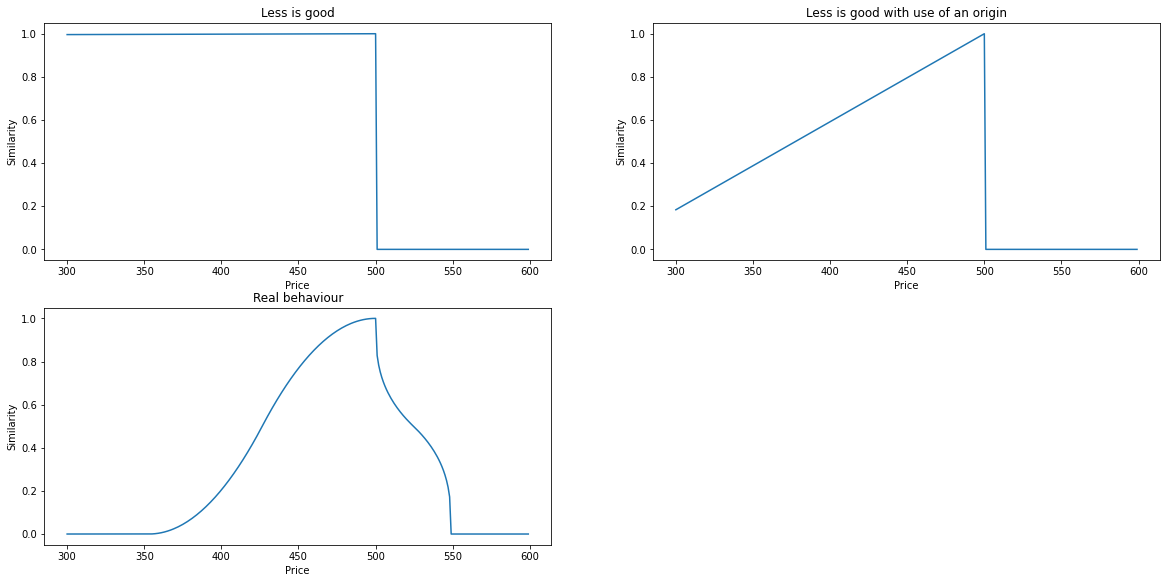

In [25]:
figure = plt.figure(2, figsize=(20, 9.6))
plt1 = figure.add_subplot(221)
plt2 = figure.add_subplot(222)
plt3 = figure.add_subplot(223)

plt1.plot(
    steps, less_is_good_values
)
plt1.set_title('Less is good')
plt1.set_xlabel(price_class.get_id())
plt1.set_ylabel('Similarity')
plt2.plot(
    steps, less_is_good_with_origin_values
)
plt2.set_title('Less is good with use of an origin')
plt2.set_xlabel(price_class.get_id())
plt2.set_ylabel('Similarity')

plt3.plot(
    steps, real_behaviour_values
)
plt3.set_title('Real behaviour')
plt3.set_xlabel(price_class.get_id())
plt3.set_ylabel('Similarity')

plt.show()

Next we will add the class ```mileage_class```, it will be of the type ```IntegerClass``` and will have the boundary of 0 and 1000000.

In [26]:
mileage_class = IntegerClass('Mileage')
mileage_min = 0
mileage_max = 1000000
mileage_class.set_predicate(RangePredicate(mileage_class.create_object(mileage_min),
                                           mileage_class.create_object(mileage_max)))

mileage_evaluator = NumberInterpolationEvaluator('MileageDefault', mileage_min, mileage_max)

query = mileage_class.read_object(mileage_max / 2) # Query value is 500000

mileage_values = list()
steps = list()
for i in range(mileage_min, mileage_max, int(mileage_max / 1000)):
    steps.append(i)
    mileage_values.append(mileage_evaluator.evaluate(query, mileage_class.read_object(i)))

We can take a look at the standard metrics of a ```NumberInterpolationMetrics``` object. 

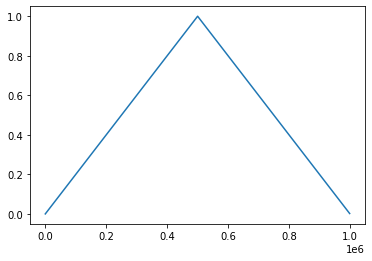

In [27]:
plt.plot(steps, mileage_values)
plt.show()

## LookupTableEvaluator
We also can define a ```brands_class``` of Type ```cbrlib.model.StringClass```.

In [28]:
brand_class = StringClass('Brand')
brands = ['Opel', 'Daimler Benz', 'BMW', 'VW']
brand_class.set_predicate(EnumerationPredicate(
                            map(lambda b: brand_class.create_object(b), brands)))

brand_similarity = {
    'Opel': {
        'VW': 0.6,
        'BMW': 0.3,
        'Daimler Benz': 0.1
    },
    'Daimler Benz': {
        'BMW': 0.8,
        'VW': 0.4,
        'Opel': 0.1
    },
    'BMW': {
        'Daimler Benz': 0.8,
        'VW': 0.6,
        'Opel': 0.1
    },
    'VW': {
        'BMW': 0.8,
        'Daimler Benz': 0.8,
        'Opel': 0.6,
    }
}
brand_evaluator = LookupTableEvaluator('Brand', brand_similarity)

If we want to know how similar the Brand ```BMW``` to ```VW``` is, we now can ask the brand evaluator:

In [29]:
print(f'BMW is {brand_evaluator.evaluate(brand_class.read_object("BMW"), brand_class.read_object("VW")) * 100}% similar to VW')

BMW is 60.0% similar to VW


## AssemblyAverageEvaluator
Or we can use the ```cbrlib.model.AssemblyClass``` to define an ```UsedCar``` descriptor and find a used car with a ```cbrlib.reasoner.LinearReasoner```

In [30]:
used_car_class = AssemblyClass('UsedCar', [
        Attribute('price', price_class),
        Attribute('mileage', mileage_class),
        Attribute('brand', brand_class)
    ])

used_car_evaluator = AssemblyAverageEvaluator('UsedCarEvaluator',
                             {
                                'price': {
                                    'weight': 2, # The price is twice as important than the rest
                                    'evaluator': real_behaviour
                                    },
                                'mileage': {
                                    'weight': 1,
                                    'evaluator': mileage_evaluator
                                },
                                'brand': {
                                    'weight': 1,
                                    'evaluator': brand_evaluator
                                }
                            })

cars = [
    {
        'brand': 'Opel',
        'price': 6600,
        'mileage': 68000
    },
    {
        'brand': 'BMW',
        'price': 8600,
        'mileage': 110000
    },
    {
        'brand': 'Daimler Benz',
        'price': 11000,
        'mileage': 21000
    },
    {
        'brand': 'VW',
        'price': 2799,
        'mileage': 550000
    },
]
reasoner = LinearReasoner(
    map(lambda c: used_car_class.read_object(c), cars), used_car_evaluator)

# Ask the reasoner now for a used car with the price of 7000 and a mileage of 75000

candidates = reasoner.infer(used_car_class.read_object({
    'price': 7000,
    'mileage': 120000
}))
print(to_json_string(candidates, indent=4))

[
    {
        "similarity": 0.9168199170617668,
        "case": {
            "brand": "Opel",
            "mileage": 68000,
            "price": 6600.0
        }
    },
    {
        "similarity": 0.32666666666666666,
        "case": {
            "brand": "BMW",
            "mileage": 110000,
            "price": 8600.0
        }
    },
    {
        "similarity": 0.26733333333333337,
        "case": {
            "brand": "Daimler Benz",
            "mileage": 21000,
            "price": 11000.0
        }
    },
    {
        "similarity": 0.04666666666666667,
        "case": {
            "brand": "VW",
            "mileage": 550000,
            "price": 2799.0
        }
    }
]


## Performance
Let us now create a ```cbrlib.reasoner.Reasoner``` from ```cbrlib.reasoner.LinearReasoner``` with a set of 1000000 random used cars.

In [31]:
used_car_class = AssemblyClass('UsedCar', [
        Attribute('price', price_class),
        Attribute('mileage0', mileage_class), # We create multiple number classes
        Attribute('mileage1', mileage_class), # to make some 'complex' description
        Attribute('mileage2', mileage_class), # for performance test.
        Attribute('mileage3', mileage_class),
        Attribute('mileage4', mileage_class),
        Attribute('brand', brand_class)
    ])
cars = []
for c in range(1000000):
    cars.append({
        'price': randint(10, 100000),
        'mileage0': randint(0, 1000000),
        'mileage1': randint(0, 1000000),
        'mileage2': randint(0, 1000000),
        'mileage3': randint(0, 1000000),
        'mileage4': randint(0, 1000000),
        'brand': choice(brands)
    })
reasoner = LinearReasoner(
    map(lambda c: used_car_class.read_object(c), cars),
    AssemblyAverageEvaluator('UsedCarEvaluator',
                             {
                                'price': {
                                    'weight': 2,
                                    'evaluator': real_behaviour
                                    },
                                'mileage': {
                                    'weight': 1,
                                    'evaluator': mileage_evaluator
                                },
                                'brand': {
                                    'weight': 1,
                                    'evaluator': brand_evaluator
                                }
                            }))

price = randint(10, 100000)      # Also lets create
mileage0 = randint(0, 1000000)   # random query values
mileage1 = randint(0, 1000000)
mileage2 = randint(0, 1000000)
mileage3 = randint(0, 1000000)
mileage4 = randint(0, 1000000)
brand = choice(brands)

loops = 100000
repetitions = 5
task = timeit.Timer(lambda: reasoner.infer(
    used_car_class.read_object({
        'price': price,
        'mileage0': mileage0,
        'mileage1': mileage1,
        'mileage2': mileage2,
        'mileage3': mileage3,
        'mileage4': mileage4,
        'brand': brand
    }), InferenceOptions({
        'skip': 0,
        'limit': 10
    })
))

measures = task.repeat(repetitions, loops)
best = reduce(lambda c, n: min(c, n), measures)

# Caution it runs about a minute!
print(f'{loops} loops, best of {repetitions}: {best*1000} ms per loop')


100000 loops, best of 5: 1888.1429960019886 ms per loop
